In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Другие способы обобщения медианы

### Выполнил: Думбай А. Д. ММП ВМК МГУ гр. 517

Рассмотрим несколько способов задания аналога медианы в многомерном пространстве и исследуем их.
Хотелось бы, что бы медиана удовлетворяла инвариантности к:
- Сдвигам
- Растяжениям
- Поворотам
- Движениям

И так же в одномерном случае должна совпадать с медианой.

Пусть

- $n - \text{число объектов}$
- $ X = \{ x_1, x_2, \dots, x_n \}- \text{множество точек, для которых мы хотим найти медиану}$
- $x_i \in \mathbb{R}^m$

Будем искать точку среди точек множества.

# Oja's Simplex Median

На лекции рассматривалась оптимизационная задача следующего вида:
### $$x_{median} = \arg \max_{\substack{x \in X}}\sum_{\substack{i = 1}}^{\substack{n}} \left|x, x_i\right|$$
После этого осуществлялся переход в многомерный случай с помощью замены модуля на некоторый похожий $\rho(x, x_i)$ и перехода к оптимизации следующего вида:
### $$x_{median} = \arg \max_{\substack{x \in X}}\sum_{\substack{i = 1}}^{\substack{n}} \rho(x, x_i)$$

__Другая идея__

В данном методе используется схожая идея. Что, если вместо интерпретации модуля, как расстояния между двумя точками, интерпретировать его как двумерный симплекс? 

Тогда в расширении на многомерный случай, вместо модуля мы рассматриваем симплекс, построенный в точке $x$ и некотором подмножестве $X \backslash \{ x\}$ мощности $m-1$ и его меру. Тогда задача оптимизации приобретет вид:
### $$x_{median} = \arg \max_{\substack{x \in X}}\sum_{\substack{  x_{i_1}, \dots, x_{i_{m-1}} \in X \backslash \{ x \}  }}^{\substack{n}} Area(Simplex(x, x_{i_1}, \dots, x_{i_{m-1}}))$$

- Данный метод устойчив к афинным преобразованиям, что решает проблему инваринатности
- Так как мы перебираем точки из множества, этот метод вернет точку из множества
- В одномерном случае симплекс превращается в отрезок и мы получаем обычную медиану

__Подводные камни__
- Симплекс может иметь нулевую меру, если набор точек по факту находился в подпространстве меньшей размерности.
    Если вообще $X$ лежит в пространстве меньшей размерности, то формально подходит любая точка. (Требуется много точек для корректной работы метода)
- В многомерном случае перебор всех симплексов оказыввается достаточно вычислительно накладной процедурой.

### Направление для исследований

При изучении этого метода возникла идея для решения проблемы с пространствами меньшей размерности. 
Интуитивно хотелось бы видеть сужение пространства.

Предлагается следующий итерационный процесс:
1. $A = X, B = R^{m}$
2. $Median$ - множество решений оптимизационной задачи c точками $B$ в пространстве $A$
3. Если в $Median$ одна точка, то заканчиваем работу
4. Иначе $A = Median, B = L(Median)$ - линейная оболочка.
5. Возвращение к п.2.

В силу вычислительной сложности при увеличении размерности как-то проанализировать это направление за разумное время не представлялось возможным.

## Эксперименты

Проведем эксперименты в двумерном случае и при прямом подходе к пересчету площадей треугольников без векторизации.

In [217]:
from itertools import combinations

In [218]:
def plot_median(X, median):
    x = X[:, 0]
    y = X[:, 1]
    
    plt.figure(figsize=(10,10))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Медиана")
    plt.scatter(X[:, 0], X[:, 1], marker='.', label='Точки выборки', s=300)
    plt.scatter(median[0], median[1], color='red', label="Медиана", s=100)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

In [219]:
def area(a, b, c):
    s = (a + b + c) / 2
    return (s*(s-a)*(s-b)*(s-c)) ** 0.5

In [220]:
def calculate_areas(X : 'np.array') -> 'np.array':
    """
    :param X: - np.array of dots, shape = (n, 2)
    :return: - np.array Y, shape = (n) -  Y[i] - mean area of triangle in X_i
    """
    n = X.shape[0]
    dist = np.sqrt(1e8 -2 * np.dot(X, X.T) + np.sum(X**2,    axis=1) + np.sum(X**2, axis=1)[:, np.newaxis])
    res = [[] for _ in range(n)]
    for i, j, k in combinations(range(X.shape[0]), 3):
        tmp = area(dist[i, j], dist[j, k], dist[k, i])
        res[i].append(tmp)
        res[j].append(tmp)
        res[k].append(tmp)
    res = np.mean(res, axis=-1)
    return res

In [221]:
def get_median(X):
    areas = calculate_areas(X)
    i = np.argmin(areas)
    median = X[i]
    return median

__Нормальное распределение__

In [227]:
X = np.random.randn(200, 2)
median = get_median(X)

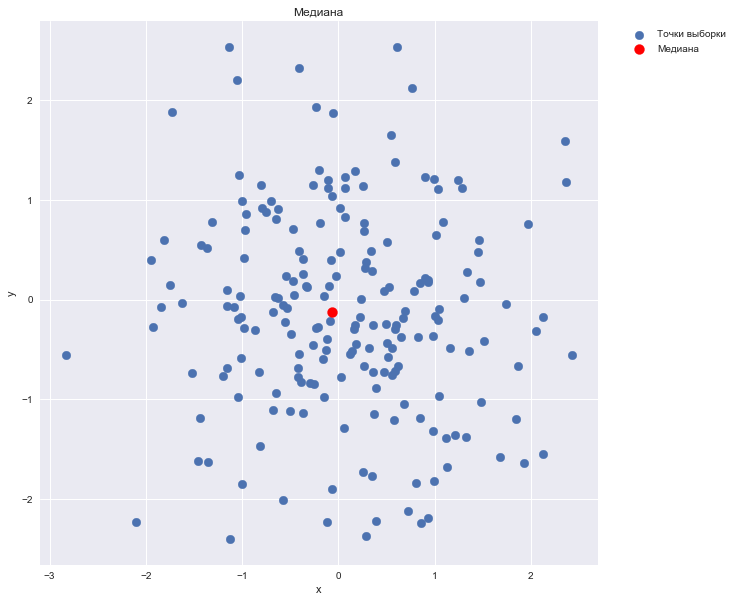

In [228]:
plot_median(X, median)

__Равномерное__

In [229]:
X = np.random.rand(200, 2)
median = get_median(X)

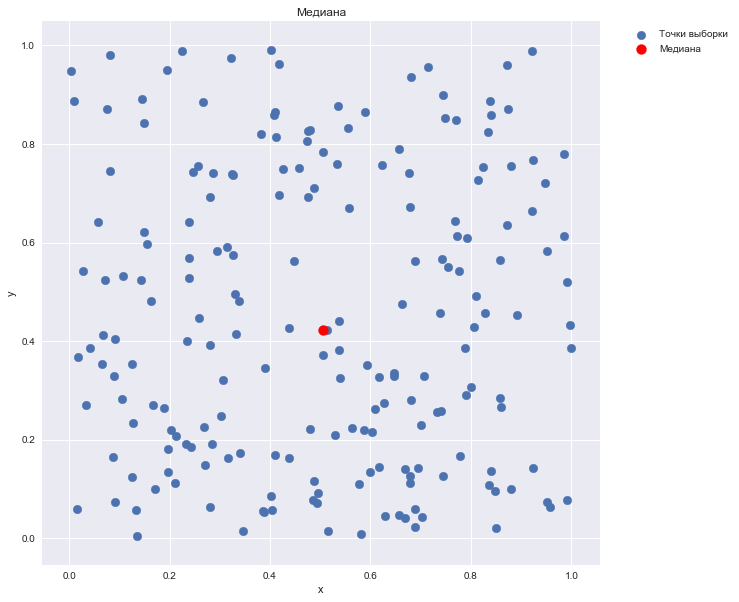

In [230]:
plot_median(X, median)

__Два кластера__

In [278]:
X_1 = np.random.rand(100, 2) + np.array([2,2])[np.newaxis, :]
X_2 = np.random.multivariate_normal((4, -4), [[0.5, 0.2], [0.2, 1]], 100)
X = np.vstack((X_1, X_2))
median = get_median(X)

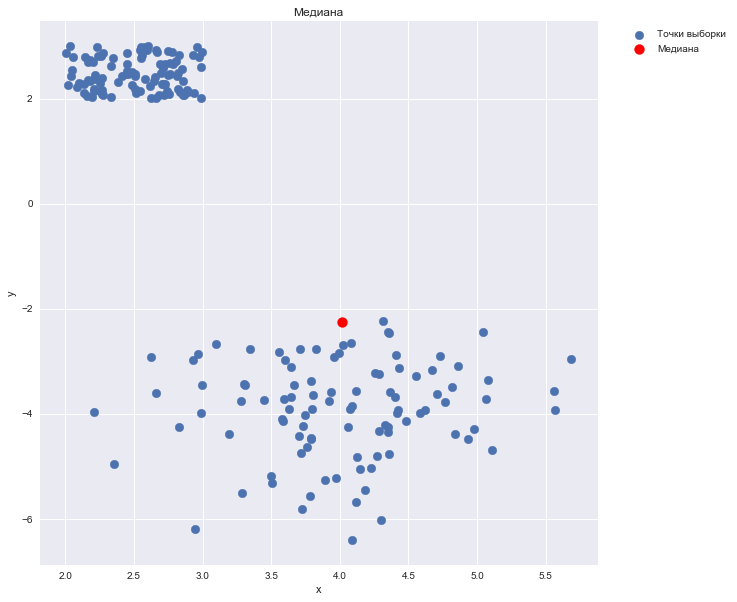

In [279]:
plot_median(X, median)

__Смесь__

In [270]:
X_1 = np.random.rand(70, 2) + np.array([2,2])[np.newaxis, :]
X_2 = np.random.multivariate_normal((2, -2), [[0.5, 0.2], [0.2, 1]], 100)
X_3 = np.random.rand(50, 2) * 2
X_4 = np.random.multivariate_normal((-2,3), [[0.7, -0.35], [-0.35, 0.5]], 70)
X = np.vstack((X_1, X_2, X_3, X_4))

In [271]:
median = get_median(X)

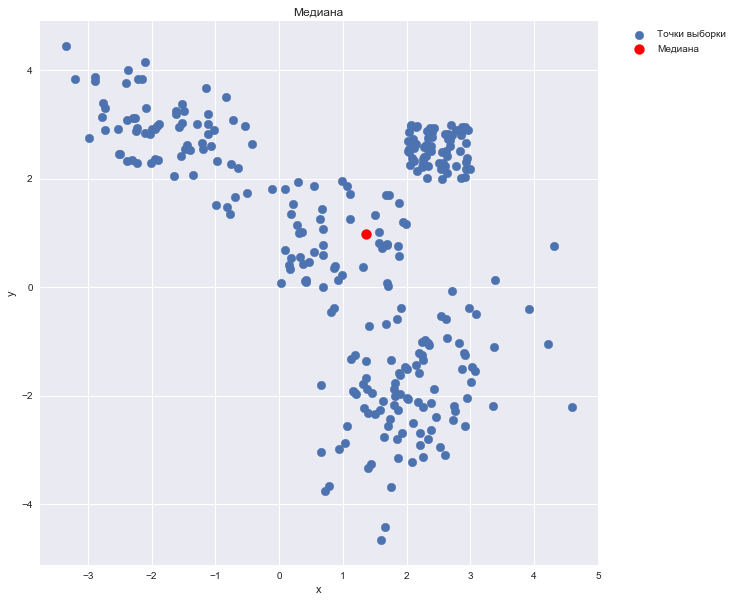

In [272]:
plot_median(X, median)

__Время__

In [273]:
X = np.random.randn(200, 2)

In [274]:
%timeit get_median(X)

3.14 s ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Выводы

Этот метод позволяет определить многомерну медиану через симплексы, но является более теоретическим, что связано с перебором всех симплексов с вершиной в каждой точке. Здесь работает проклятье размерности. 

Существует вариант приближенного поиска, но в варианте не по точкам выборки. (Computation of the multivariate Oja median
T. Ronkainen, H. Oja, P. Orponen)

Был предложен вариант итерационного алгоритма для вырожденных выборок, который, впрочем, исследован и реализован не был в рамках данной работы!